## Demo: Scenario when Shortfall is less

### Data Source for Analysis:
we will be using the dataset provided by [Open Power System Data](https://data.open-power-system-data.org/time_series/2020-10-06). This dataset contains comprehensive time series data for electricity production, consumption, and other relevant variables for various European countries.

#### Key Features of the Dataset:
- **Time series data** for energy generation, consumption, and prices.
- Covers **multiple European countries**, (Here we use Austria for our analysis).
- Includes data on **renewable energy sources** such as solar and wind generation.

This dataset is well-suited for analyzing energy market trends, modeling capacity options, and developing robust financial models to evaluate energy market instruments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from capoptix.data_loader import DataLoader

from capoptix.energymarkets.wholesale_energy_markets import DAM
from capoptix.nodal_price_generator import NodalPriceGenerator

from capoptix.generation.solar import SolarGeneration
from capoptix.generation.wind import WindGeneration
from capoptix.generation.capacity_provider import CapacityProvider

from capoptix.consumption.scaled_consumption import ScaledConsumption

from capoptix.shortfall import ShortfallAnalyzer

from capoptix.premia_model import CapacityPremiaModel 

from capoptix.utils import check_and_handle_missing_data

### Step 1: Load the necessary Data

Load Data using DataLoader.

Check whether we have zonal price information or not

In [2]:
data_loader = DataLoader(filepath="time_series_15min_singleindex_filtered.csv")
data= data_loader.load_data()
data_loader.check_price_data()

False

Since, we donot have nodal price points. we would try to estimate it in later steps from the shortfall.

In [3]:
data.columns

Index(['timestamps', 'cet_cest_timestamp', 'consumption',
       'AT_load_forecast_entsoe_transparency', 'prices', 'solar_generation',
       'wind_generation', 'hour', 'day', 'month', 'year', 'minutes'],
      dtype='object')

Also, we would like to treat all the missing data using capoptix.utils

In [4]:
data = check_and_handle_missing_data(data, columns=['prices','solar_generation','wind_generation','consumption'], trendfill=True,drop_streaks=False).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201522 entries, 0 to 201521
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   timestamps                            201522 non-null  datetime64[ns, UTC]
 1   cet_cest_timestamp                    201522 non-null  object             
 2   consumption                           201522 non-null  float64            
 3   AT_load_forecast_entsoe_transparency  201522 non-null  float64            
 4   prices                                201522 non-null  float64            
 5   solar_generation                      201522 non-null  float64            
 6   wind_generation                       201522 non-null  float64            
 7   hour                                  201522 non-null  int64              
 8   day                                   201522 non-null  int64              
 9   mont

Instantiate objects for 
- Market, 
- Capacity Provider : Solar and Wind Generation
- Demand

In [5]:
prices = DAM(data).get_market_data()

In [6]:
solar = SolarGeneration(data)
wind = WindGeneration(data)
capacity_provider = CapacityProvider(data)
capacity_provider.add_source(solar)
capacity_provider.add_source(wind)

demand = ScaledConsumption(data, capacity_provider,"per_day")

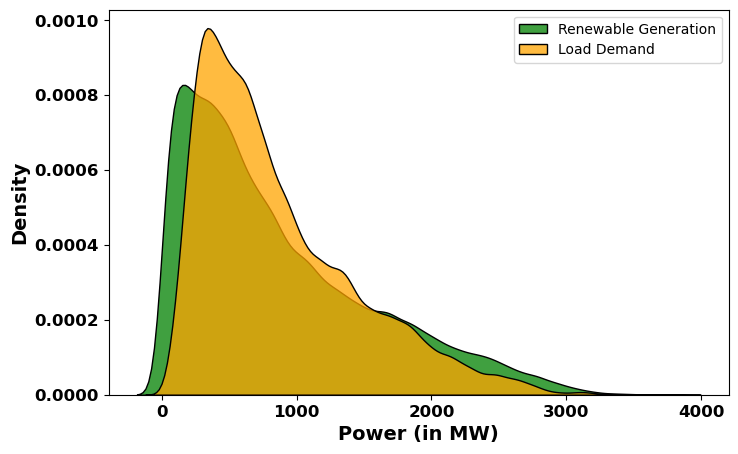

In [7]:
plt.figure(figsize=(8,5))
sns.kdeplot(capacity_provider.get_total_generation(), color= 'g',fill= True, multiple="stack")
sns.kdeplot(demand.get_consumption_data(),color = 'orange', fill= True, multiple="stack" )
plt.legend(["Renewable Generation", "Load Demand"])
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Power (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

### Step 2: Analyze Shortfall present in the Data
Next Analyze the Shortfall in the Generation compared to the Demand

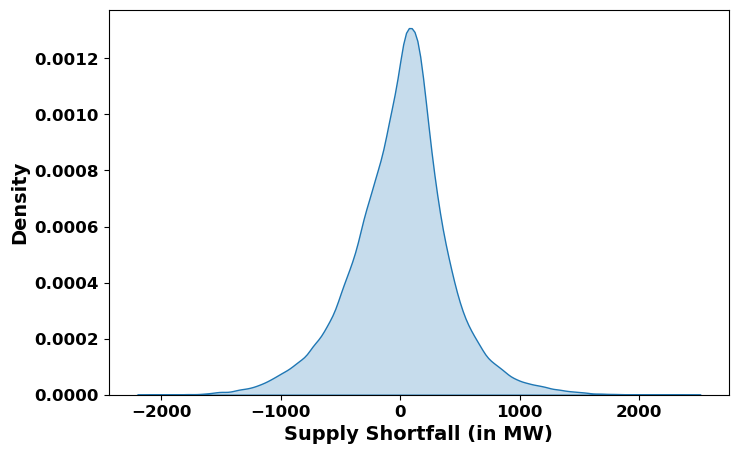

In [8]:
shortfall = ShortfallAnalyzer(capacity_provider, demand).shortfall_data
shortfall_normalized = ShortfallAnalyzer(capacity_provider, demand,"normal").shortfall_data


plt.figure(figsize=(8,5))
sns.kdeplot(shortfall, fill= True)
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Supply Shortfall (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

Check if there are any patterns in the shortfall by decomposition

In [9]:
from matplotlib import font_manager as fm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_2352/1805226136.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontproperties=fm.FontProperties(weight='bold', size=10))  # Make y-ticks bold


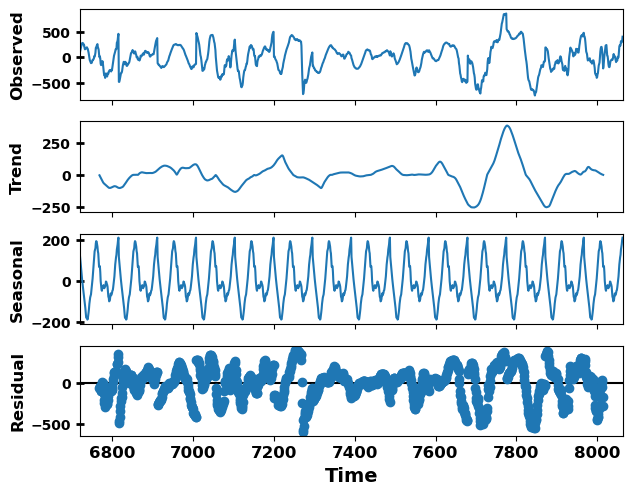

In [10]:
# plt.figure(figsize=(8,5))
decompose = seasonal_decompose(shortfall[96*7*10:96*7*12],model='additive', period=96)
fig = decompose.plot()
fig.suptitle('')
axes = fig.get_axes()
for ax, ylabel in zip(axes, ['Observed', 'Trend', 'Seasonal', 'Residual']):
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')  # Set y-label
    labels = ax.get_yticklabels()
    ax.set_yticklabels(labels, fontproperties=fm.FontProperties(weight='bold', size=10))  # Make y-ticks bold
    
    ax.tick_params(axis='y', labelsize=10,  width=2, labelrotation=0, direction='inout', length=6, grid_alpha=0.5, labelcolor='black', colors='black')  # Set y-tick boldness
    ax.set_title("")
# plt.ylabel(fontsize= 14, fontweight='bold')
plt.xlabel("Time", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
plt.title("")
plt.show()


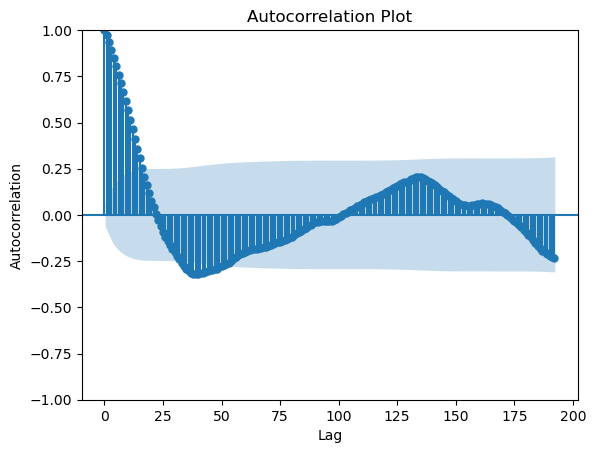

In [11]:
plot_acf(shortfall[:96*10], lags=96*2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

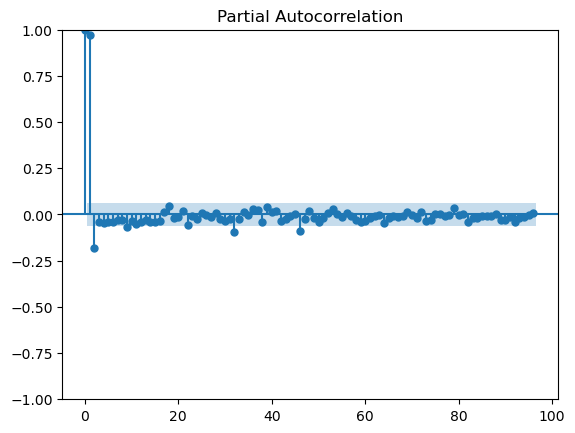

In [12]:
plot_pacf(shortfall[:96*10],lags=96);

In [13]:
shortfall_normalized.describe()

count    201522.000000
mean         -0.000516
std           0.986293
min          -5.199338
25%          -0.652673
50%           0.001005
75%           0.657781
max           5.199338
Name: QQ_Shortfall, dtype: float64

<Axes: xlabel='QQ_Shortfall', ylabel='Density'>

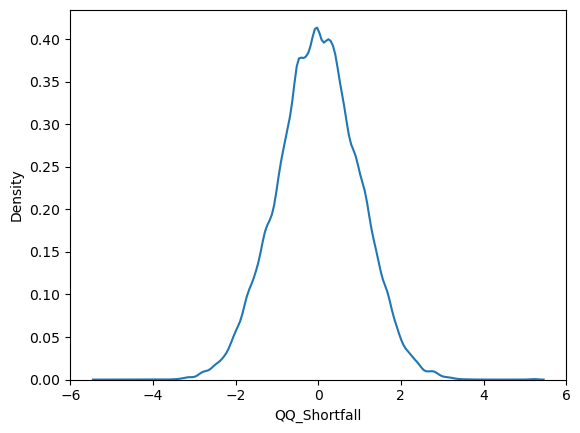

In [14]:
sns.kdeplot(shortfall_normalized)

### Step 3: Estimate nodal prices using nodalpricegenerator of capoptix

In [15]:
X=shortfall_normalized
Y=prices

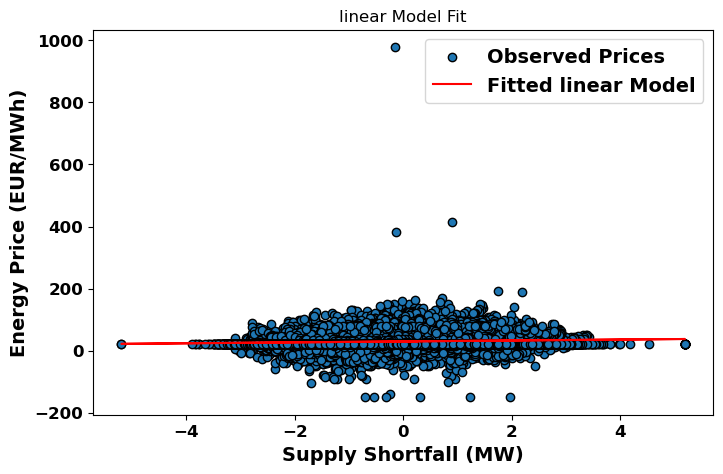

In [16]:
nodal_price_generator = NodalPriceGenerator(X,Y)
predicted_prices=nodal_price_generator.fit_model('linear')
nodal_price_generator.plot_model_fit()


<Axes: ylabel='Density'>

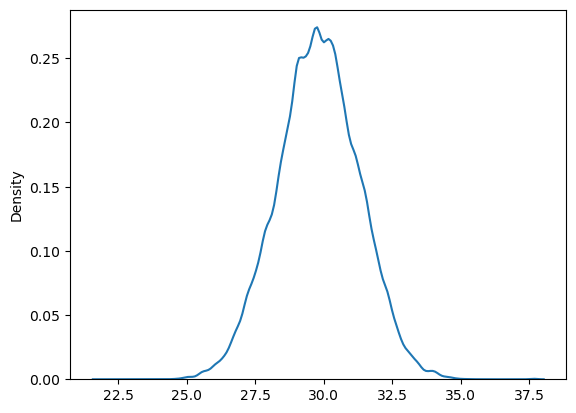

In [17]:
nodal_prices = predicted_prices
sns.kdeplot(nodal_prices)

In [18]:
nodal_prices.describe()

count    201522.000000
mean         29.798600
std           1.487499
min          21.957888
25%          28.815035
50%          29.800894
75%          30.791423
max          37.640867
dtype: float64

### Step 4: Choosing Model for Premia

Here, generation intermittently falls short of the demand and at times can produce excess too. Therefore, we use standard Brownian Motion to model underlying wholesale energy prices, since there are chances of negative values in prices as well when the generation is high and demand is low. 

We model the capacity premia using the following equation: 

$$
C(0,S_0) = \sum_{t=T}^{T+\tau} e^{-rt}m\phi(n) + e^{-rt} ( S_0 e^{rt} - K)\Phi(n)
$$
where n= $\frac{S_0e^{rt} -K}{m}$ and m =  $\sqrt{\frac{\sigma^2}{2r}(e^{2rt} -1)}$


We predominantly use Bachelier model from CapacityPremiaModel to solve the above equation. To understand how we arrive to the equation, go through our paper.

Before calling Capacity Premia Model, we need to estimate some of the fixed parameters as follows:

In [34]:
# estimation from raw increments
delta_t = 1
increments = np.diff(nodal_prices)
mu_est = np.mean(increments) / delta_t
sigma_est = np.std(increments) / np.sqrt(delta_t)

T=2  #Time to expiration : 2 years from now - time for building infrastructure
sigma = sigma_est #volatility of the wholesale energy price increments
K = np.mean(nodal_prices)       #  Strike Price
r = (2.64/100)        #  Risk-free rate - from government

wholesaleenergyprice = np.asarray(nodal_prices[67:70080+67:4])[0]   #initial wholesale energy price

tau =10*365*24 #contract period of 10 years after the expiration timeline

model=CapacityPremiaModel("bachelier")
call_price, optionp, premiums = model.premia_calculation(wholesaleenergyprice, K, r, T, tau, sigma = sigma)
print(f"the call price: {call_price}")

the call price: 462714.38346779195


In [20]:
462714.38346779195/(2*12)

19279.765977824663

Charge 19k Euros per MW per month for the timeline of 2 years until infrastructure building.